In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress, binom

from bamf.bamfC import *

import time

np.random.seed(12345)

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Design workflow:

proposed workflow
1. Collect monoculture data 
2. Design and collect plate of total OD and sequenced data 

compare prediction performance to
1. Collect monoculture data 
2. Design and collect plate of sequenced data 

# Define variable names

In [2]:
# specify fewer species than in ground truth model to make problem more challenging
species = ["s"+str(i+1) for i in range(12)]
species

['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12']

# Import test data

In [3]:
# used later for model validation
test_data = pd.read_csv("gLV_data/test_gLV_data.csv")
test_data

,Treatments,Time,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12
0,exp_1,0.0,0.057251,0.079641,0.024338,0.065582,0.058996,0.076186,0.004551,0.087550,0.016461,0.005027,0.069704,0.011079
1,exp_1,8.0,0.181500,0.041303,0.092532,0.293605,0.176399,0.095334,0.000000,0.155617,0.014650,0.012093,0.036481,0.071142
2,exp_1,16.0,0.145099,0.016104,0.138333,0.293985,0.215529,0.075262,0.057403,0.131409,0.022097,0.010484,0.033634,0.124055
3,exp_2,0.0,0.026115,0.039607,0.052088,0.003330,0.001450,0.021422,0.076977,0.008969,0.097686,0.075151,0.018731,0.051879
4,exp_2,8.0,0.163304,0.031575,0.165073,0.147545,0.019098,0.052535,0.116913,0.046885,0.050118,0.039477,0.028558,0.156299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,exp_31,8.0,0.116721,0.028401,0.107603,0.287957,0.168427,0.083846,0.104311,0.148372,0.055124,0.007911,0.007855,0.135394
92,exp_31,16.0,0.156631,0.014949,0.137977,0.289056,0.179308,0.067739,0.110668,0.128010,0.040469,0.000000,0.013803,0.153207
93,exp_32,0.0,0.060125,0.043200,0.078057,0.034261,0.044555,0.026898,0.029374,0.012404,0.011834,0.085301,0.074028,0.035561
94,exp_32,8.0,0.130950,0.019647,0.173851,0.271436,0.190970,0.071430,0.098712,0.041982,0.025532,0.028358,0.054514,0.149999


# Import monoculture data

In [4]:
init_data = pd.read_csv("gLV_data/init_gLV_data.csv")
init_data

,Treatments,Time,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12
0,mono_exp_1,0.000000,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,mono_exp_1,1.066667,0.135485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,mono_exp_1,2.133333,0.160333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,mono_exp_1,3.200000,0.186676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,mono_exp_1,4.266667,0.208772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,mono_exp_12,11.733333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.239874
188,mono_exp_12,12.800000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.258659
189,mono_exp_12,13.866667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237723
190,mono_exp_12,14.933333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.255115


# Define function to make predictions on test data

In [5]:
# Define function to make predictions on test data

def test_model(model, df_test, species, plot=False):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # save true and predicted values
    y_true = []
    y_pred = []
    y_std  = []
    test_treatments = []
    test_times = []
    all_species_names = []

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # test full community
        output, stdv, COV = model.predict(x_test, tspan)

        # save mid-point predictions of all species
        y_true.append(output_true[1])
        y_pred.append(output[1])
        y_std.append(stdv[1])
        test_times.append([tspan]*numspecies)
        all_species_names += list(species)
        test_treatments += [treatment]*numspecies

        if plot:
            # increase teval
            t_eval = np.linspace(0, tspan[-1]+1)
            steps = len(t_eval)
            output, stdv, COV = model.predict(x_test, t_eval)   
            
            # plot the results
            plt.figure(figsize=(9, 6))
            ylim = 0
            for i in range(numspecies):
                out = output[:,i]
                out_true = output_true[:, i]
                std = stdv[:, i]
                if ylim < np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1]):
                    ylim = np.max([np.max(out) + np.max(std)+.1, np.max(out_true)+.1])
                if out[0] > 0:
                    plt.scatter(tspan, out_true, color='C{}'.format(i))
                    plt.plot(t_eval, out, label=f"Predicted {species[i]}", color='C{}'.format(i))
                    plt.fill_between(t_eval, out-std, out+std, color='C{}'.format(i), alpha=0.2)

            plt.xlabel("time", fontsize=16)
            plt.ylabel("Abundance", fontsize=16)
            plt.legend(loc='upper left')
            plt.ylim([0, np.min([ylim, 3])])
            plt.title(f"Treatment {treatment} predictions")
            #plt.savefig("Kfold/Figures/{}_{}.pdf".format(dataset.replace("_",""), treatment.replace("<","")))
            #plt.close()
            plt.show()

    return np.array(test_treatments), np.array(test_times), np.array(all_species_names), np.array(y_true).ravel(), np.array(y_pred).ravel(), np.array(y_std).ravel()


# Initialize model parameters

In [6]:
# system dimensions
ns = len(species)

# map to hidden dimension
stdv = 1./np.sqrt(ns*ns)
A = np.random.uniform(0, -stdv, [ns, ns])
a = np.random.uniform(0, stdv, ns)
# c = np.zeros(ns)

# concatenate parameters 
params = np.concatenate((A.flatten(), a))
prior  = np.zeros_like(params)

n_params = len(params)
n_params

156

# Define model

In [7]:
# using gLV model 
def system(t, s, params, ctrl_params): 
    
    # map to hidden dimension
    A = jnp.reshape(params[:ns**2], [ns,ns])
    a = params[ns**2:ns**2+ns]
    # c = params[ns**2+ns:]

    # rate of change of species 
    dsdt = s * (A@s + a) # * (1. - c*s)

    return dsdt

# Define compression functions

In [8]:
# define observation matrices 
C0 = np.atleast_2d(np.ones(ns))
C1 = np.eye(ns)

# Fit model to mono culture data

In [9]:
model = ODE(system = system, 
            dataframes=[init_data],
            C = [C1],
            params = params, 
            prior = prior,
            sys_vars = species,
            measured_vars = [species],
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, beta_tol=1e-3)
print("Elapsed time {:.2f}s".format(time.time()-t0))

Updating precision...
Total samples: 180, Updated regularization: 9.07e-03
Total weighted fitting error: 59.418
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 59.41778023823566
       x: [-7.580e-02 -2.636e-02 ...  1.686e-02  7.437e-02]
     nit: 1
     jac: [-2.063e+01 -2.636e-02 ... -3.758e+00  4.042e+01]
    nfev: 3
    njev: 3
    nhev: 1
Evidence 310.532
Updating precision...
Total samples: 180, Updated regularization: 7.53e-03
Total weighted fitting error: 47.716
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 47.71624857162388
       x: [-7.364e-02 -2.636e-02 ...  1.707e-02  7.376e-02]
     nit: 1
     jac: [-3.051e+01 -2.629e-02 ... -3.057e+00  8.622e+00]
    nfev: 3
    njev: 3
    nhev: 1
Evidence 367.422
Updating precision...
Total samples: 180, Updated regularization: 4.63e-03
Total weighted fitting error: 62.868
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 62.

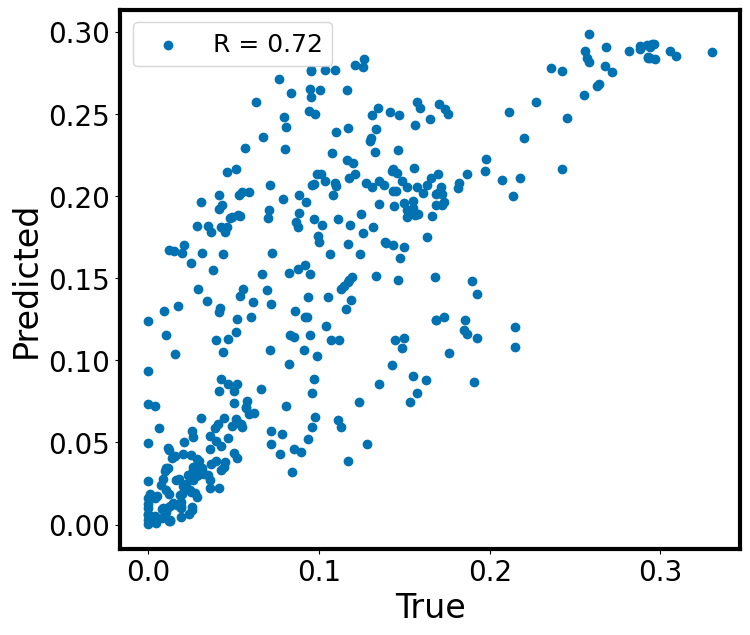

In [10]:
test_treatments, test_times, all_species_names, y_true, y_pred, y_stdv = test_model(model, test_data, species, plot=False)
R = linregress(y_true, y_pred).rvalue
plt.scatter(y_true, y_pred, label="R = {:.2f}".format(R))
plt.xlabel("True")
plt.ylabel("Predicted")
plt.legend()
plt.show()

# Select high-fidelity experiments

In [11]:
# import low resolution total od data
lr_df = pd.read_csv("gLV_data/lr_gLV_data.csv")

# import high resolution data (for sequencing)
hr_df = pd.read_csv("gLV_data/hr_gLV_data.csv")
hr_df

,Treatments,Time,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12
0,mono_exp_1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000
1,mono_exp_1,16.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.252116
2,mono_exp_2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000
3,mono_exp_2,16.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116708,0.000000
4,exp_3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,exp_4093,16.0,0.136650,0.006297,0.132832,0.287159,0.189537,0.084862,0.118691,0.112804,0.085288,0.002943,0.000000,0.138226
8186,exp_4094,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000
8187,exp_4094,16.0,0.170411,0.000000,0.155946,0.263682,0.195645,0.080487,0.076490,0.130852,0.071838,0.018274,0.032583,0.000000
8188,exp_4095,0.0,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000


In [12]:
# number of experiments to select 
N = 10

# return experiment names
seq_experiments, _ = model.search(hr_df, N, C1)

Processing design dataframe...
Computing sensitivies...
Picked exp_4095
Picked exp_3839
Picked exp_4031
Picked exp_3583
Picked exp_2031
Picked exp_2046
Picked exp_4078
Picked exp_3071
Picked exp_4063
Picked exp_1919
Dropped exp_4095
Picked exp_4085
Dropped exp_4085
Picked exp_4085


In [13]:
# collect selected od data 
od_data = lr_df.iloc[np.in1d(lr_df.Treatments.values, seq_experiments)].copy()

# collect selected sequenced data 
seq_data = hr_df.iloc[np.in1d(hr_df.Treatments.values, seq_experiments)].copy()
seq_data

,Treatments,Time,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12
3836,exp_1919,0.0,0.000000,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
3837,exp_1919,16.0,0.000000,0.000000,0.090643,0.306949,0.000000,0.162686,0.123783,0.098256,0.083485,0.003534,0.017076,0.103578
4060,exp_2031,0.0,0.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000,0.100000,0.100000,0.100000,0.100000
4061,exp_2031,16.0,0.000000,0.000757,0.135550,0.328465,0.162645,0.124718,0.150599,0.000000,0.114658,0.002498,0.005622,0.176152
4090,exp_2046,0.0,0.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.000000
4091,exp_2046,16.0,0.000000,0.007784,0.126968,0.298028,0.196868,0.108048,0.098556,0.147470,0.040282,0.013491,0.043829,0.000000
6140,exp_3071,0.0,0.100000,0.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
6141,exp_3071,16.0,0.148900,0.000000,0.146297,0.273950,0.197967,0.085875,0.129197,0.092399,0.061564,0.007198,0.012527,0.129702
7164,exp_3583,0.0,0.100000,0.100000,0.000000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
7165,exp_3583,16.0,0.185732,0.030911,0.000000,0.251819,0.174513,0.061424,0.111915,0.152515,0.038669,0.032371,0.010722,0.121459


# Train on only high resolution data

In [14]:
model = ODE(system = system, 
            dataframes=[init_data, seq_data],
            C = [C1, C1],
            params = params, 
            prior = prior,
            sys_vars = species,
            measured_vars = [species, species],
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, beta_tol=1e-3)
print("Elapsed time {:.2f}s".format(time.time()-t0))

Updating precision...
Total samples: 285, Updated regularization: 8.59e-03
Total weighted fitting error: 64.058
Total weighted fitting error: 49.628
Total weighted fitting error: 34.655
Total weighted fitting error: 26.446
Total weighted fitting error: 16.448
Total weighted fitting error: 14.867
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 14.867054168927789
       x: [-3.391e-01 -2.601e-02 ...  1.888e-02  1.206e-01]
     nit: 6
     jac: [-1.650e+00 -5.988e-02 ...  1.599e+01 -5.453e+00]
    nfev: 8
    njev: 8
    nhev: 6
Evidence 515.975
Updating precision...
Total samples: 285, Updated regularization: 6.28e-03
Total weighted fitting error: 43.190
Total weighted fitting error: 39.025
Total weighted fitting error: 33.623
Total weighted fitting error: 33.396
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 33.39623671641941
       x: [-5.884e-01 -2.326e-02 ...  1.498e-02  1.693e-01]
     nit: 4
     jac: [-3.54

In [15]:
# make test predictions
test_treatments, test_times, all_species_names, y_true, y_pred_hr, y_stdv_hr = test_model(model, test_data, species, plot=False)

# Train on low and high resolution data

In [16]:
model = ODE(system = system, 
            dataframes=[init_data, od_data, seq_data],
            C = [C1, C0, C1],
            params = params, 
            prior = prior,
            sys_vars = species,
            measured_vars = [species, ["OD"], species],
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, beta_tol=1e-3)
print("Elapsed time {:.2f}s".format(time.time()-t0))

Updating precision...
Total samples: 595, Updated regularization: 2.05e-02
Total weighted fitting error: 48.713
Total weighted fitting error: 30.397
Total weighted fitting error: 26.209
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 26.209399115944475
       x: [-7.081e-02 -2.396e-02 ...  7.959e-03  6.448e-02]
     nit: 3
     jac: [ 2.420e+00  2.387e+00 ...  2.606e+01 -2.278e+01]
    nfev: 5
    njev: 5
    nhev: 3
Evidence 978.494
Updating precision...
Total samples: 595, Updated regularization: 1.63e-02
Total weighted fitting error: 60.833
Total weighted fitting error: 54.508
Total weighted fitting error: 52.388
Total weighted fitting error: 48.394
Total weighted fitting error: 41.597
Total weighted fitting error: 36.769
Total weighted fitting error: 34.754
Total weighted fitting error: 32.094
Total weighted fitting error: 30.947
Total weighted fitting error: 30.790
Total weighted fitting error: 30.642
Total weighted fitting error: 30.577
Total 

In [17]:
# make test predictions 
test_treatments, test_times, all_species_names, y_true, y_pred_lhr, y_stdv_lhr = test_model(model, test_data, species, plot=False)

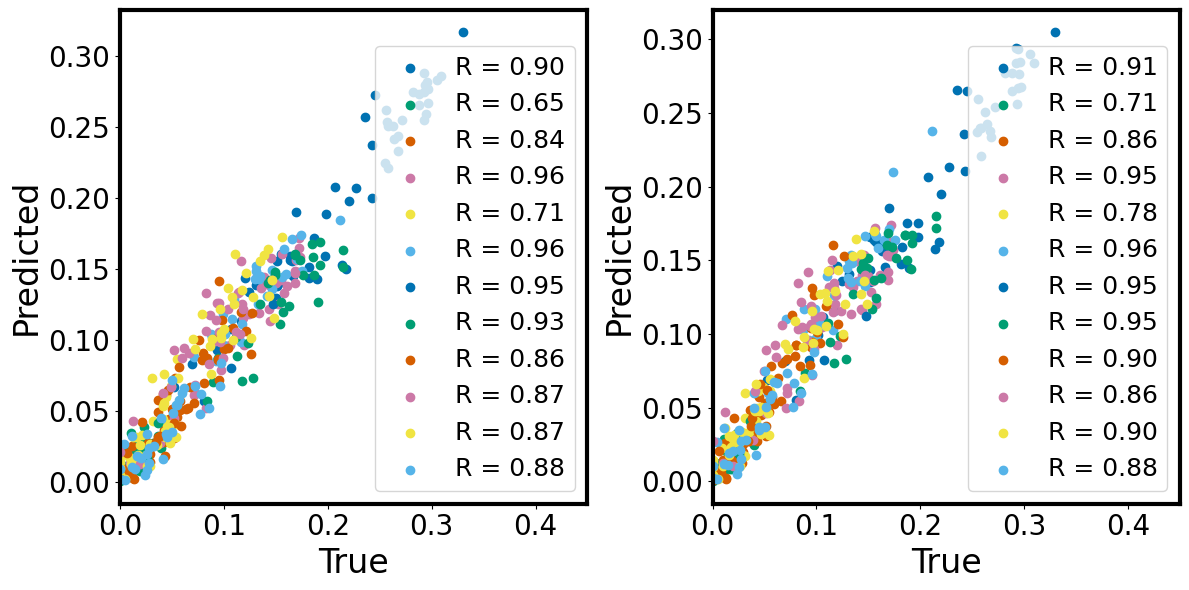

In [18]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for i, s in enumerate(np.unique(all_species_names)):
    inds = all_species_names == s
    R = linregress(y_true[inds], y_pred_hr[inds]).rvalue
    plt.scatter(y_true[inds], y_pred_hr[inds], c=f"C{i}", label="R = {:.2f}".format(R))
    plt.xlabel("True")
    plt.ylabel("Predicted")
plt.legend()
plt.xlim([0, .45])

plt.subplot(1, 2, 2)
for i, s in enumerate(np.unique(all_species_names)):
    inds = all_species_names == s
    R = linregress(y_true[inds], y_pred_lhr[inds]).rvalue
    plt.scatter(y_true[inds], y_pred_lhr[inds], c=f"C{i}", label="R = {:.2f}".format(R))
    plt.xlabel("True")
    plt.ylabel("Predicted")
plt.legend()
plt.xlim([0, .45])
plt.savefig("Results/train_seq_od.png", dpi=300)

plt.tight_layout()
plt.show()

# Sign test to compare difference in model prediction performance

### sign test 

- A non-parametric test to compare the medians of two paired samples
- Makes no assumption about the underlying distribution of the data
- The null hypothesis is that the two sets of paired samples have the same median
- Given two sets of paired samples, compute the test statistic: the number of pairs where the value of a sample in the first set is greater than the sample in the second set 
- The p-value of the test statistic is the sum of probabilities corresponding to all possible test statistics that are at least as extreme as the test statistic. 

For example, given two sets each with 10 paired samples and a test statistic of 9, the p-value is the probability of observing that 9 out of the 10 samples in the first set were greater than the corresponding samples in the second set assuming a 50% chance that a sample in the first set is greater than the corresponding sample in the second set. The p-value is therefore the sum of the probability of observing 9 out of 10 instances where the sample in set 1 was greater than the sample in set 2 plus the probability of observing 10 out of 10 instances where the sample in set 1 was greater than the sample in set 2, assuming a 50/50 chance that a sample in set 1 will be greater than a sample in set 2. The binomial distribution can be used to compute these probabilities. 

While the Mann Whitney U test could also be used, an assumption of the Mann Whitney U test is that the distribution of the differences between the two samples is symmetric around zero, which is not the case here. 

In [19]:
# compute prediction error in both cases
y_err_hr = (y_true - y_pred_hr)**2
y_err_lhr = (y_true - y_pred_lhr)**2

In [20]:
# calculate differences between the paired samples (sample 1 - sample 2)
differences = y_err_hr - y_err_lhr

# calculate test statistic (number of times sample 1 was greater than sample 2)
test_statistic = sum(differences > 0)

# calculate p-value from binomial distribution 
p_value = binom.sf(test_statistic - 1, len(differences), 0.5)

print(f"Out of {len(differences)} trials, there were {test_statistic} instances where sample 1 was greater") 
print("Under the null-hypothesis of equal chances, the p_value is {:.3f}".format(p_value))

Out of 384 trials, there were 233 instances where sample 1 was greater
Under the null-hypothesis of equal chances, the p_value is 0.000


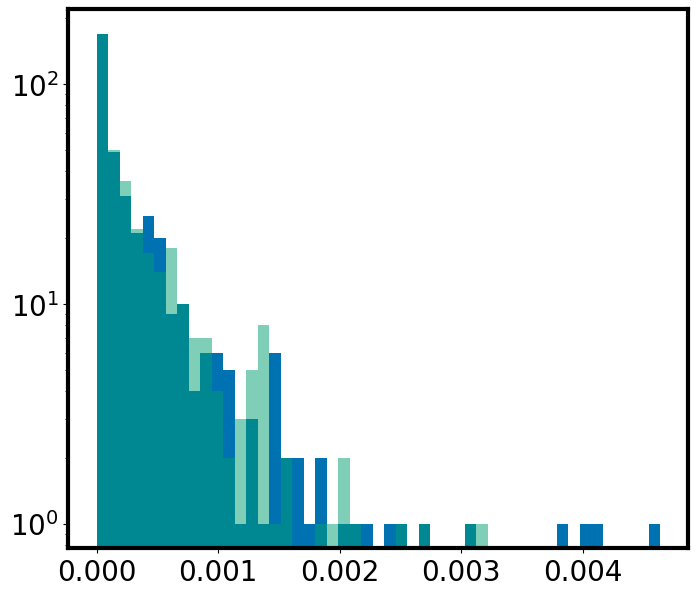

In [23]:
bins = np.linspace(0, np.max([np.max(y_err_hr), np.max(y_err_lhr)]))
plt.hist(y_err_hr, bins=bins)
plt.hist(y_err_lhr, alpha=.5, bins=bins)
plt.yscale("log")
plt.show()